In [1]:
import pandas as pd

In [4]:
# Extract projects
projects = pd.read_csv('../datasets/projects.csv')
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [5]:
tags = pd.read_csv('../datasets/tags.csv')
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [6]:
# Join projects and tags
df = pd.merge(projects, tags, on="id")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [7]:
df = df[df.tag.notnull()]

In [8]:
# Save locally
df.to_csv("../datasets/labeled_projects.csv", index=False)

In [11]:
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

In [18]:
tag, tag_counts = zip(*Counter(df.tag.values).most_common())

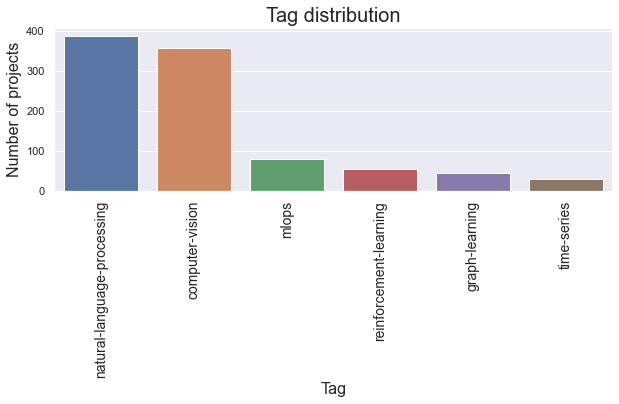

In [23]:
# Distribution of tags
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [27]:
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

In [28]:
# Most frequent tokens for each tag
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

In [38]:
df['text'] = df.title + ". " + df.description

In [33]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [34]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [35]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [36]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [41]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

comparison yolo rcnn real world video bring theori experi cool easili train model colab find result minut
comparison yolo rcnn real world video bring theori experi cool easili train model colab find result minut


In [42]:
# Accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

In [43]:
# Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [44]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,awesom mont carlo tree search curat list mont ...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,deep reinforc learn tensorflow2 deep rl tf2 re...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,distribut rl use tensorflow2 implement variou ...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,prophet forecast scale tool produc high qualit...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,curriculum reinforc learn curriculum learn app...


In [45]:
# Replace this tag with `other`
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,awesom mont carlo tree search curat list mont ...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,deep reinforc learn tensorflow2 deep rl tf2 re...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,distribut rl use tensorflow2 implement variou ...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,prophet forecast scale tool produc high qualit...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,curriculum reinforc learn curriculum learn app...


In [46]:
# Minimum frequency required for a tag
min_freq = 75
tags = Counter(df.tag.values)

In [49]:
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('other', 87),
 ('mlops', 79),
 ('graph-learning', 45)]

In [51]:
# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=388), Output()), _dom_classes=('widget-i…

In [52]:
# Filter tags that have fewer than <min_freq> occurrences
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if (tags[tag] >= min_freq))
df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)

In [54]:
# Fill None with `other`
df.tag = df.tag.fillna("other")

### Encoding

In [55]:
import numpy as np
import random

In [56]:
X = df.text.to_numpy()
y = df.tag

In [59]:
class LabelEncoder(object):
    """Encode labels into unique indices."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [60]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [61]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [62]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [63]:
# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [64]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


### Splitting

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [67]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

In [68]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [69]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

In [70]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [71]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

In [72]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [73]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [74]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


In [75]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

In [76]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,ufod unifi framework object detect ufod open s...,computer-vision
1,electra pre train text encod discrimin pytorch...,natural-language-processing
2,scispaci full spaci pipelin model scientif bio...,natural-language-processing
3,goturn pytorch pytorch implement learn track 1...,computer-vision
4,visual neural machin translat model mechan seq...,natural-language-processing


### Augmentation

In [80]:
import nlpaug.augmenter.word as naw

In [81]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

In [82]:
text = "Conditional image generation using Variational Autoencoders and GANs."

In [84]:
# Substitutions
substitution.augment(text)

['expected value conversion via variational autoencoders and simulations.']

In [85]:
# Insertions
insertion.augment(text)

['standard conditional array image generator generation technique using linear variational autoencoders and gans.']

In [86]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

In [87]:
# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

In [88]:
# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

In [89]:
print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [90]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [91]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [92]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [93]:
from snorkel.augmentation import transformation_function

In [94]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.""" 
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)  
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [95]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning natural language processing tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks


In [96]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc


In [97]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [98]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:01<00:00, 541.71it/s]


,text,tag
0,ufod unifi framework object detect ufod open s...,computer-vision
1,electra pre train text encod discrimin pytorch...,natural-language-processing
2,scispaci full spaci pipelin model scientif bio...,natural-language-processing
3,goturn pytorch pytorch implement learn track 1...,computer-vision
4,visual neural machin translat model mechan seq...,natural-language-processing


In [99]:
len(train_df), len(train_df_augmented)

(668, 823)